# **Written exam Economics 2022-23**
**Advanced Macro economics: Structural Vector Autoregressive (VAR) Analysis**


The topic for this project examination is exchange rate determination. Under the assumptions that Purchasing Power Parity and Uncovered Interest Rate Parity hold and that money demand depends on real income and the nominal interest rate, the exchange rate between two countries is determined by the relative output levels and the relative money supplies. Recent empirical research suggests that uncertainty, in addition to fundamentals, also significantly
affect exchange rates. Our aim in this examination is to evaluate whether uncertainty is important for exchange rate determination.

The purp ose of the examination is to assess your understanding of structural vector autoregressive (VAR) models. Substantial emphasis will be placed on using your programming skills in MATLAB. Specifically, the examination assesses theoretical and practical knowledge of structural vector autoregressive models within stationary and non-stationary frameworks including assessing empirical results, using different approaches to identify VAR models and be able to use MATLAB to generate empirical results. You can use any MATLAB functions that you have programmed yourself or any function uploaded to Absalon during the course except when otherwise stated. You are not allowed to use other programs or built-in MATLAB functions except for those that are specified in the questions below. The assignment requires some additional coding.

Most questions in the examination are applied, concerning the empirical example outlined below. When you answer these empirical questions, please explain and motivate your answers as detailed as p ossible, preferably with reference to the underlying theory.

Consider the following data generating process (DGP). Let the time series vector $x_t=\begin{pmatrix} \ln(Y_t)&\ln(M_t)&\ln(S_t)&UN_t\end{pmatrix}´$ where $\ln(Y_t)=y_t$ is relative output, $M_t=m_t$ is the relative money supply, $\ln(S_t)=s_t$ is the exchange rate measured as home currency units $p$ er unit foreign currency (implying that a rise in s implies a depreciation of the currency whereas a fall implies an appreciation) and $UN_t$ is a measure of economic uncertainty. We assume that
the time series vector is generated by the following VAR model 

$$x_t=\nu+A_1x_{t−1}+\cdots+A_px_{t−p}+u_t\tag{1}$$

where $\nu$ is a constant and $u_t$ is a vector of reduced form residuals with covariance matrix $\Sigma_u$. Assume that this time series vector is integrated of order one and that the cointegration rank is $r$.

We will assume that there are two cointegration vectors in this system, the first vector is consistent with the standard monetary approach to the exchange rate $(s_t=m_t-\phi y_t)$ and then we assume that uncertainty $(UN_t)$ is a stationary process which is intuitive since uncertainty cannot grow without limits. We then have the following cointegration vector

$$\beta=\begin{pmatrix}
-\phi&1&−1&0\\
0&0&0&1
\end{pmatrix}
$$


Under these assumptions we can rewrite the VAR model as the following VECM 

$$\Delta x_t=\nu+\alpha\beta'x_{t−1}+\Gamma_1\Delta x_{t−1}+\cdots+\Gamma_{p−1}\Delta x_{t−p−1}+u_t\tag{2}$$

The assignment will guide you through an empirical analysis of the time series vector stated above including estimation and analysis of the cointegrated VAR model, identification of the structural cointegrated VAR model and robustness analysis.

This solution is based on the dataset `1000.mat`.

<center>

### $\text{Preamble}$

</center>

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.font_manager import FontProperties
font_props = FontProperties(family='Times New Roman', size=10)
import seaborn as sns
sns.set_palette("pastel") 
 
from IPython.display import display, Math, clear_output
from sympy import Matrix
from sympy import latex, symbols

from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import jarque_bera
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import het_arch
from statsmodels.tsa.tsatools import vech

from scipy.optimize import least_squares
from scipy.optimize import fsolve
import scipy.stats as stats
from scipy.stats import chi2
from scipy.stats import f

from pathlib import Path
import pandas as pd
import numpy as np
import random
import sys
import os

import warnings
warnings.filterwarnings("ignore", message="Setting `xtol` below the machine epsilon")
warnings.filterwarnings("ignore", message="Setting `gtol` below the machine epsilon")
warnings.filterwarnings("ignore", category=RuntimeWarning)

%load_ext autoreload
%autoreload 2

current_dir = Path.cwd()
sys.path.append(f"{current_dir}")

# Save output:
Python_path = None
LaTeX_path = None # LaTeX editor Texifier for macOS (https://www.texifier.com) highly recommended


pd.options.display.float_format = '{:.4f}'.format  # Ændrer til 4 decimale4

color_navy = '#{:02x}{:02x}{:02x}'.format(85, 108, 131)
colors_navy = ["#a5c6e2", "#80afd6", "#5b97ca", "#3b7fb9", "#2f6694", "#234c6f", "#17334a", "#0b1925"]
colors_pastel = sns.color_palette("pastel", 10)
colors_pastel

[(0.6313725490196078, 0.788235294117647, 0.9568627450980393),
 (1.0, 0.7058823529411765, 0.5098039215686274),
 (0.5529411764705883, 0.8980392156862745, 0.6313725490196078),
 (1.0, 0.6235294117647059, 0.6078431372549019),
 (0.8156862745098039, 0.7333333333333333, 1.0),
 (0.8705882352941177, 0.7333333333333333, 0.6078431372549019),
 (0.9803921568627451, 0.6901960784313725, 0.8941176470588236),
 (0.8117647058823529, 0.8117647058823529, 0.8117647058823529),
 (1.0, 0.996078431372549, 0.6392156862745098),
 (0.7254901960784313, 0.9490196078431372, 0.9411764705882353)]

In [1]:
# Data:
result = pd.read_excel(f'{current_dir}/Data & Estimates/1000_2022.xlsx')

# Very important:
list_of_info = ["Dates: 1998-2019 (Monthly)","Output","Money Supply", "Exchange Rate","Economic Uncertainty"]
list_of_info_latex = [r"$\ln(Y_t)$", r"$\ln(M_t)$",r"$\ln(S_t)$",r"$UN_t$"]

K = len(result.drop(columns=["Dates"]).columns)

# Package/module:
from Structural_Vector_Autoregressive_Analysis import BaseClass

# Initialiser BaseClass med ønskede parametre
Base_initialize = BaseClass(LaTeX_path = None,                          # Can be None or LaTeX_path if LaTeX_path =! None it will save Tables/Plots to the LaTeX_path
                            Python_path = Python_path,                  # Path to Python folder
                            list_of_info_latex = list_of_info_latex,    # List of variable
                            list_of_info = list_of_info,                # List of names for each variable 
                            # Path to JCV.npy, PSSCV.npy and SigLevels.xlsx
                            path = f"{current_dir}/Data & Estimates/")    

from Structural_Vector_Autoregressive_Analysis import Initial_Tools as SVAR_IT
SVAR_IT = SVAR_IT(Base_initialize, date_column="Dates")

## $\text{Q1}$
The data is already in natural logarithms (including uncertainty) and ordered as in $x_t$. Plot the data and perform graphical analysis in order to assess the degree of integration of all four variables.

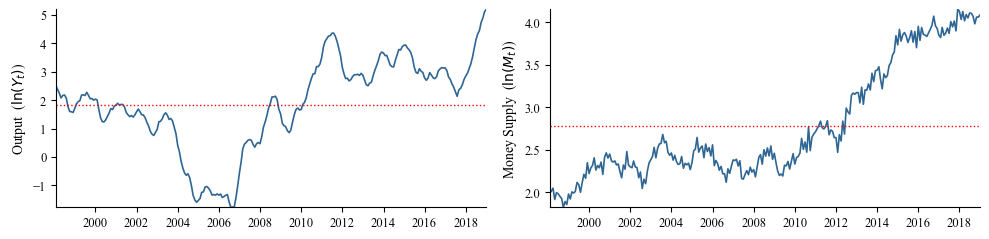

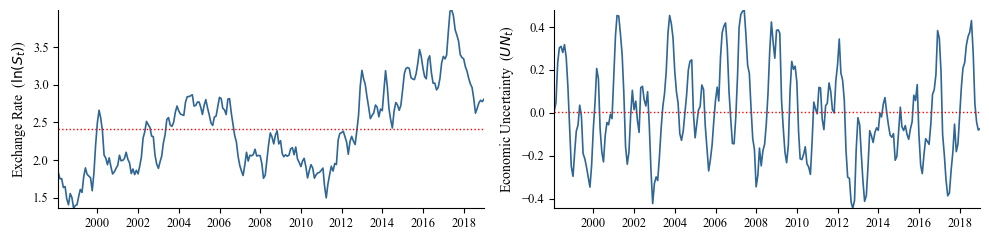

All variables have the same sample size: 252


,Mean,Median,Min,Max,Std. Dev.
Output,1.8395,2.0035,-1.7744,5.2100,1.5932
Money Supply,2.7777,2.4720,1.8258,4.1559,0.6721
Exchange Rate,2.4185,2.3695,1.3599,3.9926,0.5526
Economic Uncertainty,0.0043,-0.0208,-0.4452,0.4799,0.2152


In [2]:
SVAR_IT.Data_plot(result,Save=False)
SVAR_IT.Descriptive_Statistics(result, display_data=True)
y_clean_data = SVAR_IT.clean_data(result,display_data=False)

## $\text{Q2}$
Formulate a well-specified VAR model for $x_t$. Explain your workflow and how you argue for your choice of the numb er of autoregressive lags in the VAR model

In [3]:
from Structural_Vector_Autoregressive_Analysis import Lag_Order_Determination as SVAR_LOD
SVAR_LOD = SVAR_LOD(Base_initialize, y_dataframe=y_clean_data)

from Structural_Vector_Autoregressive_Analysis import Diagnostic_Testing as SVAR_DT
SVAR_DT = SVAR_DT(Base_initialize, y_dataframe=y_clean_data)
 
from Structural_Vector_Autoregressive_Analysis import Univariate_Diagnostic_Testing as SVAR_UDT
SVAR_UDT = SVAR_UDT(Base_initialize, y_dataframe=y_clean_data)

from Structural_Vector_Autoregressive_Analysis import Testing_Cointegration as SVAR_TC
SVAR_TC = SVAR_TC(Base_initialize, y_dataframe=y_clean_data)

In [4]:
_ = SVAR_LOD.Information_Criteria(maximum_lag_length=12, Trend=False, Show=True)

Lag,SIC,HQ,AIC
0,-6.154227,-6.188864,-6.212238
1,-17.272542,-17.445725,-17.562595
2,-18.561145,-18.872874,-19.083241
3,-18.234076,-18.684352,-18.988215
4,-17.951329,-18.540151,-18.937510
5,-17.624761,-18.352130,-18.842985
6,-17.325621,-18.191536,-18.775887
7,-17.051725,-18.056187,-18.734034
8,-16.753133,-17.896140,-18.667484
9,-16.465945,-17.747499,-18.612339


In [5]:
SVAR_LOD.Top_Down_Sequence(maximum_lag_length=12, Trend = False, Show=False)

,Lag,Log. Likelihood,LR test,p-value
0,0,-1498.9371,,
1,1,-4255.0228,2756.0856,0.0000
2,2,-4651.9778,396.9550,0.0000
3,3,-4661.1715,9.1937,0.9052
4,4,-4681.0024,19.8309,0.2279
5,5,-4690.3164,9.3140,0.8999
6,6,-4706.2129,15.8965,0.4602
7,7,-4728.1682,21.9553,0.1446
8,8,-4744.1961,16.0279,0.4510
9,9,-4762.9613,18.7651,0.2810


In [6]:
SVAR_LOD.Combined_Lag_Selection(maximum_lag_length=12, Trend = False, LaTeX=False)

Lag,SIC,HQ,AIC,LR Test
0,-6.154,-6.189,-6.212,
1,-17.273,-17.446,-17.563,2756.086***
2,-18.561,-18.873,-19.083,396.955***
3,-18.234,-18.684,-18.988,9.194
4,-17.951,-18.540,-18.938,19.831
5,-17.625,-18.352,-18.843,9.314
6,-17.326,-18.192,-18.776,15.896
7,-17.052,-18.056,-18.734,21.955
8,-16.753,-17.896,-18.667,16.028
9,-16.466,-17.747,-18.612,18.765


## $\text{Q3}$
Test for multivariate auto correlation, heteroscedasticity and normality. Do es your model satisfy the underlying assumptions? If the multivariate tests of auto correlation and ARCH reject the null hypotheses, apply univariate tests for auto correlation and ARCH in the residuals in each equation. You are allowed to use the built-in MATLAB functions lb qtest and archtest as alternatives to own functions.

In [7]:
SVAR_DT.Eigenvalue_Short_Table(maximum_lag_length=3, LaTeX=False)

Lag,"No Constant, No Trend",Constant Only,Trend Only,Constant and Trend
1,1.003085,0.988643,0.985617,0.960382
2,1.003087,1.000843,0.996511,0.973096
3,1.003295,1.000605,0.996786,0.976197


In [8]:
Constant = True
Trend = False
p = 2 # VAR Lags

_, _, _, residuals, _, SIGMA = SVAR_DT.VAR_estimation_with_exogenous(lags=p,Constant=Constant,Trend=Trend)
lags_q = 2 # ARCH Lags
lag_h = 6  # Autocorrelation (LM and Portmanteau)

In [9]:
SVAR_DT.Multivariate_ARCH(residuals=residuals, lags_q=lags_q)

,Test,Doornik_Hendry
0,Test statistic,227.0347
1,P-value,0.0921
2,Degrees of freedom,200.0000


In [10]:
SVAR_DT.Multivariate_Normality(residuals=residuals)

,Test,Doornik_Hansen,Lutkepohl
0,Joint test statistic:,5.6735,5.7356
1,P-value,0.6837,0.6768
2,Degrees of freedom,8.0000,8.0000
3,Skewness only,4.0169,3.9165
4,P-value,0.4037,0.4174
5,Kurtosis only,1.6565,1.8191
6,P-value,0.7986,0.7690


In [11]:
SVAR_DT.Multivariate_Portmanteau(residuals=residuals, lag_h=lag_h, lags=p)

,,Portmanteau,Modified Portmanteau
0,Test Statistic,65.4727,66.5657
1,p-value,0.4254,0.3887
2,Degrees of Freedom,64.0000,64.0000


In [12]:
SVAR_DT.Autocorrelation_LM_Table(lags=p, Constant=Constant, Trend=Trend, Exogenous=None, lags_h=lag_h, LaTeX=False)

Lags (h),Breusch Godfrey,Edgerton Shukur
1,9.188,0.55
2,30.935,0.929
3,38.513,0.765
4,55.059,0.82
5,80.137,0.963
6,93.486,0.933


In [13]:
SVAR_DT.Diagnostic_Table(residuals = residuals, 
                         Constant = Constant, 
                         lags_q = lags_q, 
                         lags_h = lag_h,
                         Trend = Trend, 
                         lags = p,
                         LaTeX = False)

,Doornik Hendry,Doornik Hansen,Lutkepohl,Portmanteau,Portmanteau Modified
Joint test,227.035*,5.673,5.736,65.473,66.566
Skewness test,,4.017,3.917,,
Kurtosis test,,1.657,1.819,,


#### $$\text{Univariate Tests for {\small ARCH}, Normality, and Autocorrelation}$$

In [14]:
print("\nUnivariate ARCH Test - Het_ARCH")
display(SVAR_UDT.Univariate_ARCH_Test(residuals=residuals,lags=p))
print("\nUnivariate Normality Test - Jarque_Bera")
display(SVAR_UDT.Univariate_Normality_Test(residuals=residuals))
print("\nUnivariate Autocorrelation Test - Ljung-Box")
display(SVAR_UDT.Univariate_Autocorrelation_Test(residuals=residuals, lag_h=lag_h))

SVAR_UDT.Combined_Univariate_LaTeX(residuals=residuals,lags=p,lag_h=lag_h, LaTeX=False)


Univariate ARCH Test - Het_ARCH


,Hypothesis,P-Value,Test Statistic,Critical Value
Output,0.0000,0.2616,2.6821,5.9915
Money Supply,1.0000,0.0145,8.4658,5.9915
Exchange Rate,0.0000,0.8266,0.3808,5.9915
Economic Uncertainty,0.0000,0.0807,5.0338,5.9915



Univariate Normality Test - Jarque_Bera


,Hypothesis,P-Value,Test Statistic,Critical Value
Output,0.0000,0.5376,1.2414,5.9915
Money Supply,0.0000,0.8743,0.2687,5.9915
Exchange Rate,0.0000,0.1835,3.3911,5.9915
Economic Uncertainty,0.0000,0.7600,0.5490,5.9915



Univariate Autocorrelation Test - Ljung-Box


,Output,Money Supply,Exchange Rate,Economic Uncertainty
Lag 1,0.0001,1.1319,0.1802,0.0779
Lag 2,0.0067,2.2256,0.1849,1.0046
Lag 3,0.0302,2.6777,0.2277,1.4015
Lag 4,0.0531,2.6895,0.6094,1.5488
Lag 5,0.5378,4.552,0.6226,2.3095
Lag 6,0.5522,4.6409,5.8291,2.9862


## $\text{Q4}$
For your preferred model, proceed by testing for cointegration using the MATLAB function jcitest. Explain your approach and how you find the number of cointegration vectors, that is, the rank $r$, in the system allowing for ($i$) a constant term in the cointegration vector and ($ii$) both a constant and a linear trend in the cointegration vector. Do you use different sources of information when determining the rank? If so, explain how you arrive at your decision

In [15]:
_ = SVAR_TC.Trace_Test(lags=p, p_value_threshold=0.05, LaTeX=False)

,1/H2/n,2/H1*/co,3/H1/ci,4/H*/cili,5/H/colo
0,176.816*** (λ=0.3251),182.839*** (λ=0.3358),176.981*** (λ=0.3351),183.682*** (λ=0.3366),182.075*** (λ=0.3365)
1,78.519*** (λ=0.2419),80.543*** (λ=0.242),74.942*** (λ=0.2377),81.094*** (λ=0.2379),79.504*** (λ=0.2377)
2,9.276 (λ=0.0286),11.273 (λ=0.0362),7.094 (λ=0.0279),13.172 (λ=0.0328),11.647 (λ=0.0303)
3,2.017 (λ=0.008),2.063 (λ=0.0082),0.013 (λ=0.0001),4.825 (λ=0.0191),3.965** (λ=0.0157)
Pantula,2,2,2,2,2


Sample: 250. Lag length: VAR: p=2 and VEC: p=1. Test statistic with Eigenvalue
in parentheses and the significance level as a superscript (10%, 5% and 1%).
Pantula principle at a 5%


In [16]:
cointegration_vectors, rank = SVAR_TC.Cointegration_Vectors(preferred_model=3, 
                                lags=p, p_value_threshold=0.05, 
                                normalise_on_element=[0,3], 
                                rank=None,LaTeX=True)

# Alternatively, for normalise_on_element use [1, 1, 1, 1] or [1,2,3,4],  
# but if so the length must equal 1 or K

Model: 3  |  Model: H1 ("ci") [constant in coint vec and linear trend in levels] 

  Rank determined automatically using the Pantula principle
     Rank: 0 LR: 176.981 p-value: 0.001 ( *** ) and λ = 0.3351
     Rank: 1 LR: 74.942 p-value: 0.001 ( *** ) and λ = 0.2377
     Rank: 2 LR: 7.094 p-value: 0.6025 (  ) and λ = 0.0279

 \begin{pmatrix}  1.00000 & -4.63964 & 4.90579 & 4.30403 \end{pmatrix} 

 \begin{pmatrix}  -0.19428 & 0.97051 & -0.97539 & 1.00000 \end{pmatrix} 


In [17]:
cointegration_vectors4, rank4 = SVAR_TC.Cointegration_Vectors(preferred_model=4, 
                                lags=p, p_value_threshold=0.05, 
                                normalise_on_element=[0,3], 
                                rank=None,LaTeX=True)

# Alternatively, for normalise_on_element use [1, 1, 1, 1] or [1,2,3,4],  
# but if so the length must equal 1 or K

Model: 4  |  Model: H* ("cili") [constant and linear trend in coint vec, linear trend in levels] 

  Rank determined automatically using the Pantula principle
     Rank: 0 LR: 183.682 p-value: 0.001 ( *** ) and λ = 0.3366
     Rank: 1 LR: 81.094 p-value: 0.001 ( *** ) and λ = 0.2379
     Rank: 2 LR: 13.172 p-value: 0.7282 (  ) and λ = 0.0328

 \begin{pmatrix}  1.00000 & -4.39813 & 4.88871 & 4.25906 \end{pmatrix} 

 \begin{pmatrix}  -0.19297 & 0.93576 & -0.96648 & 1.00000 \end{pmatrix} 


## $\text{Q5}$
Impose your preferred rank and test the null hyp othesis that there is no linear trend in the cointegration vectors.

In [18]:
LRtest, pval, _, Arest, Brest, _, _, _, _ = \
    SVAR_TC.johcontest(r=rank, test=['bcon'], cons=SVAR_TC.zero_array(K+1)[K], model='H*', lags=float(p-1), alpha=0.05)

threshold = 0.05

decision = "cannot reject" if pval > threshold else "reject"
conclusion = "include a constant but not\na trend" if pval > threshold else "include both a constant\nand a trend"

print(f"The LR test statistic is {LRtest:.4f} with a p-value of {pval:.4f}.\n"
      f"We {decision} the null that the trend in the cointegration \n"
      f"vector is zero, suggesting we should {conclusion}.")

print("\n   The freely estimated cointegration vector:")

display(Math(r"\begin{equation}\beta="+SVAR_IT.To_Matrix(Brest.T)+r"'\end{equation}"))

The LR test statistic is 0.6227 with a p-value of 0.7325.
We cannot reject the null that the trend in the cointegration 
vector is zero, suggesting we should include a constant but not
a trend.

   The freely estimated cointegration vector:


<IPython.core.display.Math object>

## $\text{Q6}$
Imp ose your preferred rank and the preferred specification of the deterministic component in the cointegration vector found in the previous question and test hyp otheses on the cointegration space using the MATLAB function jcontest. Test for exclusion, stationarity and weak exogeneity. Explain the meanings of these tests.

In [19]:
print(f"For rank = {rank} and lags = {p-1}")
SVAR_TC.Stationary_Exclusion_Exogeneity(rank=float(rank), lags=p, LaTeX=False)

# Long run time

For rank = 2 and lags = 1


,,Stationarity,,Exclusion,,Weak Exogeneity
Output,,63.724***,,59.173***,,44.111***
Money Supply,,67.798***,,77.454***,,36.518***
Exchange Rate,,62.779***,,81.679***,,49.487***
Economic Uncertainty,,0.914,,79.249***,,43.526***


## $\text{Q7}$
Interpret the unrestricted estimated cointegration vectors in light of the theoretical cointegration vectors. Do you find plausible values of the parameters in the estimated cointegration vectors? Interpret the unrestricted estimates of the adjustment parameters

In [20]:
display(Math(r"\begin{equation}\beta="+SVAR_IT.To_Matrix(-Arest)+r"'\end{equation}"))

<IPython.core.display.Math object>

## $\text{Q8}$
Test formally whether the theoretical cointegration vectors are in line with the information in the data using the MATLAB function jcontest. Explain how these tests relate to the exclusion and stationarity tests. These tests also provide an estimate of the parameter $\phi$ in the cointegration vector. Report your estimate of $\phi$. In case you fail in finding $\phi$, assume that it is equal to 0.5

$$\beta=\begin{pmatrix}
-\phi&1&−1&0\\
0&0&0&1
\end{pmatrix}
$$

In [21]:
RR = np.transpose(np.array([[0, 1, 1, 0],[0, 0, 0, 1]], dtype=np.float64))  # Ensure it's a double
RR = np.transpose(np.array([[0, 0, 0, 1],[0, 1, 1, 0]], dtype=np.float64))  # Ensure it's a double

LRtest, pval, dof, Arest, Brest, c0r, c1r, d0r, d1r = \
    SVAR_TC.johcontest(r=rank, test=['bcon'], cons=RR, model='H1', lags=float(p-1), alpha=0.05)

phi = (Brest/Brest[1])[0][0]
print(phi)

-0.2101109566630772


In [22]:
(RR @ Brest.T) @ SVAR_TC.null(RR @ Brest.T)[1]
#phi = -0.2128

array([[0.0000, 0.0000],
       [0.0000, 0.0000],
       [0.0000, 0.0000],
       [0.0000, 0.0000]])

In [23]:
RR = np.transpose(np.array([[phi,1,-1,0],[0,0,0,1]], dtype=np.float64))  # Ensure it's a double

LRtest, pval, _, _, Brest, _, _, _, _ = \
    SVAR_TC.johcontest(r=rank, test=['bvec'], cons=RR, model='H1', lags=float(p-1), alpha=0.05)

threshold = 0.05

decision = "cannot reject" if pval > threshold else "reject"
conclusion = "do" if pval > threshold else "do not"
plural = "relationships" if int(rank) > 1 else "relationship"

print(f"The LR test statistic is {LRtest:.4f} with a p-value of {pval:.4f}. This\n"
      f"suggests that we {decision} the null that the cointegration\n"
      f"{plural} {conclusion} exist in the cointegration space")

print("\n   The cointegration vector:")

display(Math(r"\begin{equation}\beta="+SVAR_IT.To_Matrix(Brest.T)+r"'\end{equation}"))

The LR test statistic is 2.2984 with a p-value of 0.6811. This
suggests that we cannot reject the null that the cointegration
relationships do exist in the cointegration space

   The cointegration vector:


<IPython.core.display.Math object>

## $\text{Q9}$
Plot both the unrestricted and theoretical cointegration vectors. Interpret your results

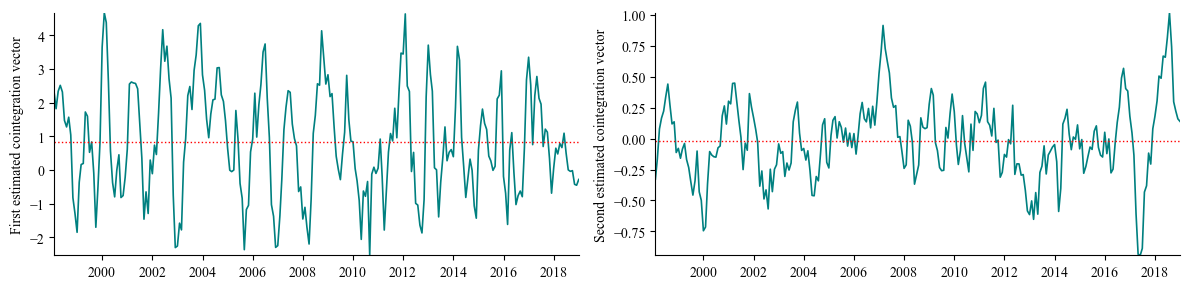

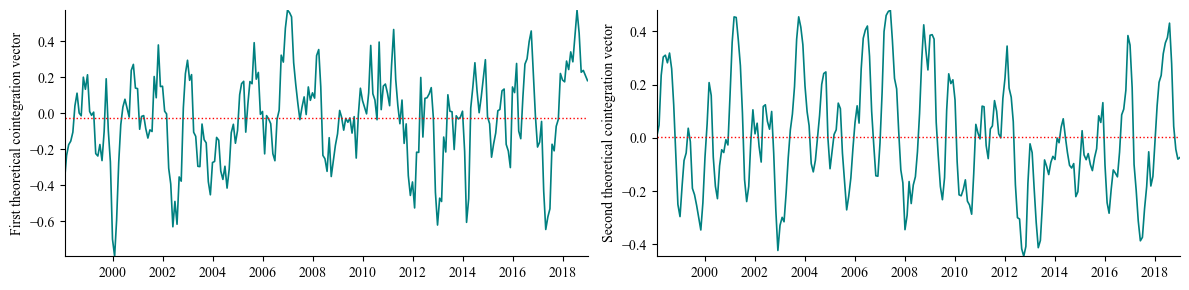

The correlation between coint1 and theo1 is: -0.8163
The correlation between coint2 and theo2 is:  0.6134


In [24]:
coint1 = np.dot(cointegration_vectors[0],np.array(y_clean_data).T)     # need to multiply with -1 to match Matlab
coint2 = np.dot(cointegration_vectors[1],np.array(y_clean_data).T)

fig, axs = plt.subplots(1, 2, figsize=(12, 3))
SVAR_IT.setup_axis(axs[0], result['Dates'], coint1, f"First estimated cointegration vector", font_props, "Teal", mean_line=True,special_data_format=[False,10])
SVAR_IT.setup_axis(axs[1], result['Dates'], coint2, f"Second estimated cointegration vector", font_props, "Teal", mean_line=True,special_data_format=[False,10])
plt.tight_layout()
plt.show()

theo1 = np.dot(np.array([phi,1,-1,0]),np.array(y_clean_data).T)     # need to multiply with -1 to match Matlab
theo2 = np.dot(np.array([0,0,0,1]),np.array(y_clean_data).T)

fig, axs = plt.subplots(1, 2, figsize=(12, 3))
SVAR_IT.setup_axis(axs[0], result['Dates'], theo1, f"First theoretical cointegration vector", font_props, "Teal", mean_line=True,special_data_format=[False,10])
SVAR_IT.setup_axis(axs[1], result['Dates'], theo2, f"Second theoretical cointegration vector", font_props, "Teal", mean_line=True,special_data_format=[False,10])
plt.tight_layout()
plt.show()

print(f"The correlation between coint1 and theo1 is: {round(np.corrcoef(coint1, theo1)[0, 1],4)}")
print(f"The correlation between coint2 and theo2 is:  {round(np.corrcoef(coint2, theo2)[0, 1],4)}")

## $\text{Q10}$
Impose $r=2$ and the theoretical cointegration vectors and re-estimate the VEC model using the full sample and using your preferred lag length found above. Interpret the adjustment coefficients in light of the theoretical cointegration vectors. Do you find the exp ected signs on the adjustment coefficients?

In [25]:
for i, val in enumerate(list_of_info):
    print(f"{i}: {val}" + (f" ({list_of_info_latex[i-1]})" if i > 0 else ""))

0: Dates: 1998-2019 (Monthly)
1: Output ($\ln(Y_t)$)
2: Money Supply ($\ln(M_t)$)
3: Exchange Rate ($\ln(S_t)$)
4: Economic Uncertainty ($UN_t$)


In [26]:
from Structural_Vector_Autoregressive_Analysis import Identification_Restrictions_Cointegrated_SVAR as SVAR_IRC
SVAR_IRC = SVAR_IRC(Base_initialize,y_dataframe=y_clean_data, horizon = 25, lags=p, Constant=Constant, Trend=Trend, Exogenous=None)
phi = -0.2128
Beta_theory = np.array([[phi,1,-1,0],[0,0,0,1]])
rank = 2

linear_combinations = None # {"Real Interest": [f"{list_of_info[2]} - {list_of_info[3]}"],
#                        "Monetary Base": [f"{list_of_info[4]} - {list_of_info[3]}"]
#                        }

print("\nLinear Combinations")
if not linear_combinations:
    linear_combinations = None
    print("  None")
else:
    for name, expressions in linear_combinations.items():
        for expr in expressions:
            print(f"  {name} = {expr}")

The estimated VAR model may be unstable due to largest absolute eigenvalue is greater than or equal to 1. 
Review the model specification for potential adjustments.
Max Eigenvalue = 1.001


Linear Combinations
  None


In [27]:
beta = SVAR_TC.Initilize_beta_vecm(lags=p,model=3, beta_theory=Beta_theory.T, rank=int(rank)).T
Beta, Betavec, SEBeta, tratioBeta, res, so, so_ml = SVAR_TC.LSKnownBeta(lags=p, beta=beta, model= 3)
Beta = Beta.T
tratioBeta = tratioBeta.T

GAMMA = Beta[:,0:K*(p-1)]       # first diff lags
alpha = Aest = Beta[:,K*(p-1):len(Beta.T)-1]   # speed of adjustment

tratioBeta_re = tratioBeta.reshape(-1, Beta.shape[1])
alpha_tratio = tratioBeta_re[:,K*(p-1):len(tratioBeta_re.T)-1]

print("Least Squares:")
print("Alpha estimates:\n",alpha.T,"\n")
print("Alpha t-ratios: \n",alpha_tratio.T)

alpha, Gamma, SigmaML, u = SVAR_IRC.VECMknown(beta=Beta_theory.T)

print("\nMaximum Likelihood ")
print("Alpha estimates: \n",alpha.T)

print("\nEquivalent: ~",np.allclose((alpha - Beta[:,K*(p-1):len(Beta.T)-1]),0))

Least Squares:
Alpha estimates:
 [[0.2065 -0.0792 0.2568 0.0441]
 [-0.1340 -0.1292 -0.0972 -0.1930]] 

Alpha t-ratios: 
 [[6.1953 -3.1064 7.1604 1.4875]
 [-4.2641 -5.3718 -2.8752 -6.9084]]

Maximum Likelihood 
Alpha estimates: 
 [[0.2065 -0.0792 0.2568 0.0441]
 [-0.1340 -0.1292 -0.0972 -0.1930]]

Equivalent: ~ True


## $\text{Q11}$
Suggest an identification scheme including names of the four structural shocks in the VAR/VEC system using a combination of long-run and short-run restrictions. If you cannot provide names for these shocks, try to explain how they affect the data under the maintained assumptions

In [28]:
SVAR_TC.Identication_Scheme(rank)

Since the rank r = 2, there are 2 transitory/temporary shocks.
Thus, there are K-r = 2 permanent shocks.

    To identify the permanent shocks, we need (K-r)(K-r-1)/2 = 1 restrictions. (Upsilon)
    To identify the transitory shocks, we need r(r-1)/2 = 1 restrictions. (B^{-1}_0)


In [29]:
B_R = """[ * * * *
           * * * *
           * * * *
           * * 0 * ]"""

U_R = """[ * 0 0 0 
           * * 0 0 
           * * 0 0  
           0 0 0 0 ]"""

## $\text{Q12}$
Implement the identification scheme using the MATLAB solver. Check that the solver provides a valid identification and compute the variance-covariance matrix of the identified structural shocks. Please, provide the MATLAB code you are using to identify the shocks in the appendix. It must include a description of the restrictions you impose to
identify the structural model

$$\textcolor{red}{\texttt{ML = True}}$$

In [30]:
Xi, SIGMA, _ = SVAR_IRC.Implement_identication(model = 3, rank=rank, beta = Beta_theory.T,ML=True)

invB0 = least_squares(lambda B0inv_flat: SVAR_IRC.Restrictions(B0inv_flat, B0inv_R=B_R, Upsilon_R=U_R, Xi=Xi, SIGMA=SIGMA,Beta=Beta_theory),
                        np.random.randn(K * K))#, xtol=1e-1000000, gtol=1e-1000000, max_nfev=30000)

B0inv = invB0.x.reshape((K, K))
B0inv[:, B0inv.diagonal() < 0] *= -1

print("B_0^{-1}(B_0^{-1})'-\Sigma = 0        ",np.allclose((B0inv @ B0inv.T - SIGMA), 0))
print("\\beta'\\Upsilon = 0                    ",np.allclose((Beta_theory @ Xi @ B0inv), 0))
print("(B_0^{-1} \Sigma @ B_0^{-1})' = I_K   ",np.allclose((np.linalg.inv(B0inv) @ SIGMA @ np.linalg.inv(B0inv).T), np.eye(K)))
Upsilon_solve = Xi @ B0inv
B0inv_solve = B0inv

print("\nB^{-1}_0 =\n",SVAR_IT.To_Matrix(B0inv,short=False))
print("\n\\Upsilon =\n",SVAR_IT.To_Matrix(Xi @ B0inv,short=False))

B_0^{-1}(B_0^{-1})'-\Sigma = 0         True
\beta'\Upsilon = 0                     True
(B_0^{-1} \Sigma @ B_0^{-1})' = I_K    True

B^{-1}_0 =
 \begin{pmatrix}
0.07298 & -0.01097 & 0.05243 & 0.03458 \\
0.00421 & 0.04990 & -0.03242 & 0.04407 \\
-0.06565 & 0.03511 & 0.06993 & 0.02096 \\
-0.02358 & -0.05758 & 0.00000 & 0.05956 \\
\end{pmatrix}

\Upsilon =
 \begin{pmatrix}
0.36855 & 0.00000 & -0.00000 & 0.00000 \\
0.02928 & 0.05686 & 0.00000 & -0.00000 \\
-0.04914 & 0.05686 & 0.00000 & -0.00000 \\
0.00000 & 0.00000 & 0.00000 & 0.00000 \\
\end{pmatrix}


## $\text{Q13}$
Compute impulse response functions and forecast error variance decomposition of the data. Focus first on the effects of uncertainty shocks. Use bootstrap (the standard residual based recursive design bootstrap or wild bootstrap) to compute confidence intervals based on bootstrap standard error estimates (for the impulse resp onses) and Efron's
percentile intervals (for the variance decomposition). It is important that you clearly state which bootstrap method you use and how you check the order condition in each bootstrap replication. You can show forecast error variance decomposition either in a table or in a graph. Interpret your results

In [31]:
irf = SVAR_IRC.IRF(B0inv=B0inv,VEC=True,VAR=False,alpha=alpha,beta=Beta_theory.T)
fevd = SVAR_IRC.FEVD_IRF(irf)

IRF_result = SVAR_IRC.IRF_estimation(IRF_var=irf, list_of_info=list_of_info, normalise=None)
FEVD_result = SVAR_IRC.FEVD_estimation(FEVD_var=fevd, list_of_info=list_of_info, normalise=None)

In [32]:
IRFmat, VCmat = SVAR_IRC.VEC_Bootstrap(Bootstrap = True, 
                                       Bootstrap_type = "Wild", 
                                       Orthogonal = False, 
                                       iterations = None, 
                                       B0inv_R = B_R, 
                                       Upsilon_R = U_R, 
                                       rank = rank,
                                       n_trials=399, 
                                       Beta_theory = Beta_theory, 
                                       Umat = None, 
                                       Upsilon0 = None,
                                       estimator = "Numerical", 
                                       initial_guess = B0inv,
                                       linear_combinations = None) # None or linear_combinations

Initial settings and model checks
      Xi satisfies assumptions
      Identification of transitory shocks is valid
      Solver works correctly.

Numerical Solver (least_squares)

Trial: 399 of 399  |  Failures due to solver: 0 | Failures due to unstable eigenvalue: 0

  Bootstrap based on: 399 trials
  Estimator type in use: Numerical
  Bootstrap type in use: Wild

Total errors: 0
     Errors due to unstable replications: 0
     Errors due to Xi not satisfying assumptions: 0
     Errors due to solver failure to converge: 0


Impulse Response Function
Bootstrap (Wild) Confidence Intervals (Delta)


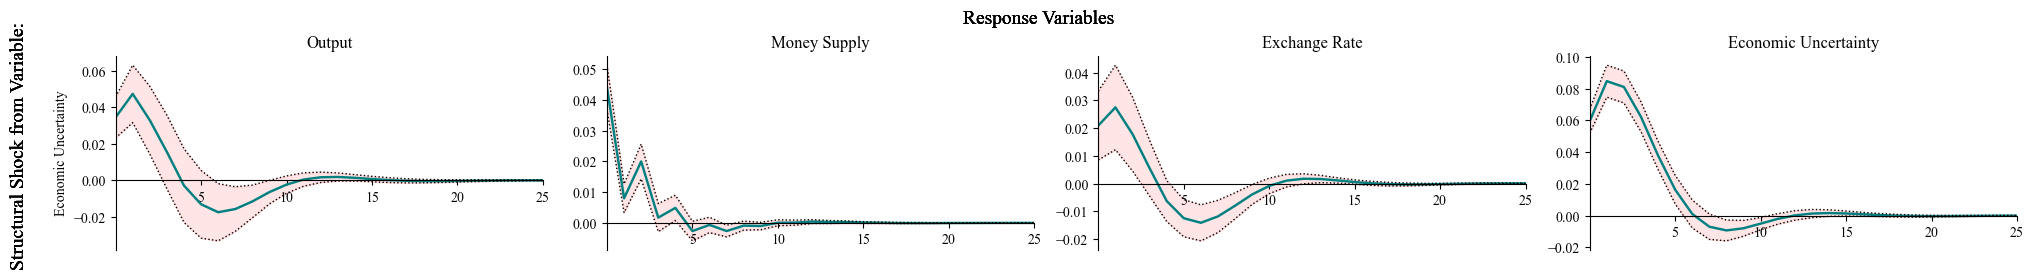

In [33]:
SVAR_IRC.IRF_Combined_Plots(
    linear_combinations = None, # None or linear_combinations
    Bootstrap_Matrix = IRFmat,
    confidence_type = "Delta",  # or "Efron" can be extended.
    responses = [1,2,3,4],      # None = All = [1,2,...,K] and can be any combination e.g [3,1]
    shocks = [4],         # None = All = [1,2,...,K] and can be any combination e.g [2]
    z_values = [68],            # mulitple e.g. z_values=[95,68]
    Baseline = irf,             
    Info="Wild",                # VEC_Bootstrap() setting
    )

Forecast Error Variance Decomposition
Bootstrap (Wild) confidence intervals (Efron)


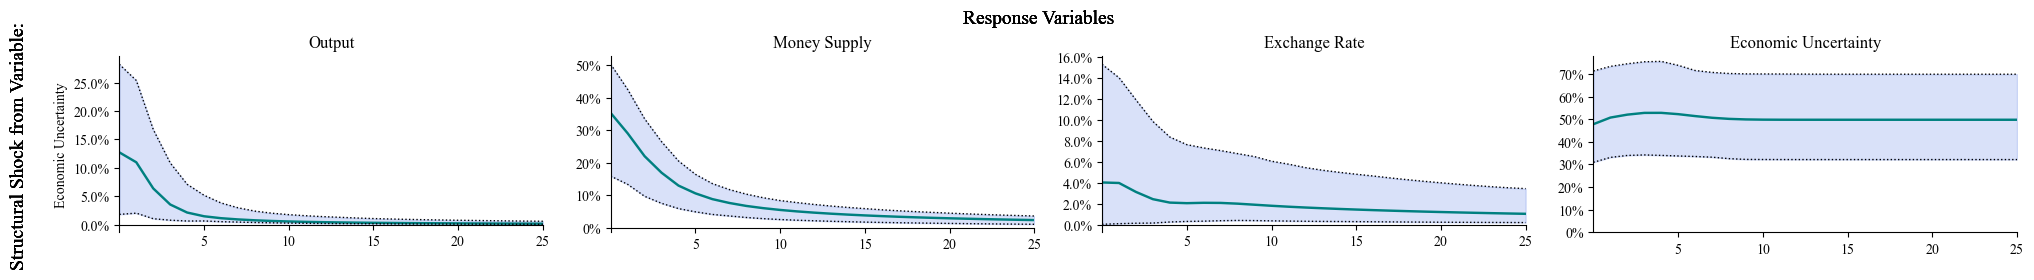

In [34]:
SVAR_IRC.FEVD_Combined_Plots(
    Bootstrap_Matrix = VCmat,
    confidence_type ="Efron", # can be extended.
    responses = [1,2,3,4], # None = All = [1,2,...,K] and can be any combination e.g [3,1]
    shocks = [4],  # None = All = [1,2,...,K] and can be any combination e.g [2]
    z_values = [68], # mulitple e.g. z_values=[95,68]
    Baseline = fevd*100, 
    Info="Wild",
    )

## $\text{Q14}$
Show the complete estimates of the forecast error variance decomp osition of the exchange rate and interpret the results. Are uncertainty shocks relatively more important for exchange rates than sho cks to the fundamentals?

Forecast Error Variance Decomposition
Bootstrap (Wild) confidence intervals (Efron)


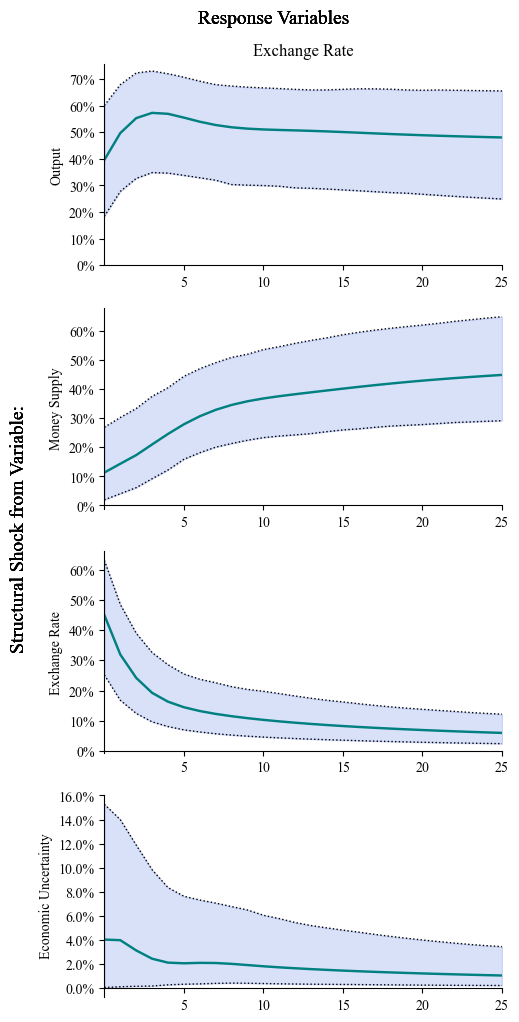

In [35]:
SVAR_IRC.FEVD_Combined_Plots(
    Bootstrap_Matrix = VCmat,
    confidence_type ="Efron", # can be extended.
    responses = [3], # None = All = [1,2,...,K] and can be any combination e.g [3,1]
    shocks =[1,2,3,4],  # None = All = [1,2,...,K] and can be any combination e.g [2]
    z_values = [68], # mulitple e.g. z_values=[95,68]
    Baseline = fevd*100, 
    Info="Wild",
    )

## $\text{Q15}$
Instead of implementing the theoretical cointegration vector you can use the estimated cointegration vector still imposing $r=2$. Identify the structural sho cks using the same identification scheme as above and plot the implied impulse responses of the data to uncertainty sho cks together with confidence bands. Compare your results to what you previously found using the theoretical cointegration vector. Comment! 

If you fail computing the $B^{-1}_0$ matrix using the MATLAB solver, please use the `ident.p` file again. The code is generic and works for any cointegration vector. However, you may not be able to interpret your results in light of economic theory

In [36]:
cointegration_vectors

[array([1.0000, -4.6396, 4.9058, 4.3040]),
 array([-0.1943, 0.9705, -0.9754, 1.0000])]

In [37]:
Beta_theory = np.array(cointegration_vectors)
alpha, Gamma, SigmaML, u = SVAR_IRC.VECMknown(beta=Beta_theory.T)

In [38]:
B_R = """[ * * * *
           * * * *
           * * * *
           * * 0 *]"""

U_R = """[ * 0 0 0
           * * 0 0
           * * 0 0 
           * * 0 0]"""

In [39]:
Xi, SIGMA, _ = SVAR_IRC.Implement_identication(model = 3, rank=rank, beta = Beta_theory.T,ML=True)

invB0 = least_squares(lambda B0inv_flat: SVAR_IRC.Restrictions(B0inv_flat, B0inv_R=B_R, Upsilon_R=U_R, Xi=Xi, SIGMA=SIGMA,Beta=Beta_theory),
                        np.random.randn(K * K))# xtol=1e-1000000, gtol=1e-1000000, max_nfev=30000)

B0inv = invB0.x.reshape((K, K))
B0inv[:, B0inv.diagonal() < 0] *= -1

print("B_0^{-1}(B_0^{-1})'-\Sigma = 0        ",np.allclose((B0inv @ B0inv.T - SIGMA), 0))
print("\\beta'\\Upsilon = 0                    ",np.allclose((Beta_theory @ Xi @ B0inv), 0))
print("(B_0^{-1} \Sigma @ B_0^{-1})' = I_K   ",np.allclose((np.linalg.inv(B0inv) @ SIGMA @ np.linalg.inv(B0inv).T), np.eye(K)))

print("\nB^{-1}_0 =\n",SVAR_IT.To_Matrix(B0inv,short=False))
print("\n\\Upsilon =\n",SVAR_IT.To_Matrix(Xi @ B0inv,short=False))

B_0^{-1}(B_0^{-1})'-\Sigma = 0         True
\beta'\Upsilon = 0                     True
(B_0^{-1} \Sigma @ B_0^{-1})' = I_K    True

B^{-1}_0 =
 \begin{pmatrix}
0.07391 & -0.01219 & 0.05154 & 0.03388 \\
0.00372 & 0.05074 & -0.03111 & 0.04425 \\
-0.06430 & 0.03367 & 0.07142 & 0.01976 \\
-0.02369 & -0.05737 & 0.00000 & 0.05957 \\
\end{pmatrix}

\Upsilon =
 \begin{pmatrix}
0.36749 & 0.00000 & -0.00000 & -0.00000 \\
0.02875 & 0.05653 & 0.00000 & -0.00000 \\
-0.04628 & 0.05475 & 0.00000 & -0.00000 \\
-0.00164 & -0.00146 & 0.00000 & 0.00000 \\
\end{pmatrix}


In [40]:
irf = SVAR_IRC.IRF(B0inv=B0inv,VEC=True,VAR=False,alpha=alpha,beta=Beta_theory.T)
fevd = SVAR_IRC.FEVD_IRF(irf)

IRF_result = SVAR_IRC.IRF_estimation(IRF_var=irf, list_of_info=list_of_info, normalise=list_of_info[4])
FEVD_result = SVAR_IRC.FEVD_estimation(FEVD_var=fevd, list_of_info=list_of_info, normalise=list_of_info[4])

In [41]:
IRFmat, VCmat = SVAR_IRC.VEC_Bootstrap(Bootstrap = True, 
                                       Bootstrap_type = "Wild", 
                                       Orthogonal = False, 
                                       iterations = None, 
                                       B0inv_R = B_R, 
                                       Upsilon_R = U_R, 
                                       rank = rank,
                                       n_trials=399, 
                                       Beta_theory = Beta_theory, 
                                       Umat = None, 
                                       Upsilon0 = None,
                                       estimator = "Numerical", 
                                       initial_guess = B0inv,
                                       linear_combinations = None) # None or linear_combinations

Initial settings and model checks
      Xi satisfies assumptions
      Identification of transitory shocks is valid
      Solver works correctly.

Numerical Solver (least_squares)

Trial: 399 of 399  |  Failures due to solver: 0 | Failures due to unstable eigenvalue: 0

  Bootstrap based on: 399 trials
  Estimator type in use: Numerical
  Bootstrap type in use: Wild

Total errors: 0
     Errors due to unstable replications: 0
     Errors due to Xi not satisfying assumptions: 0
     Errors due to solver failure to converge: 0


Impulse Response Function
Bootstrap (Wild) Confidence Intervals (Delta)


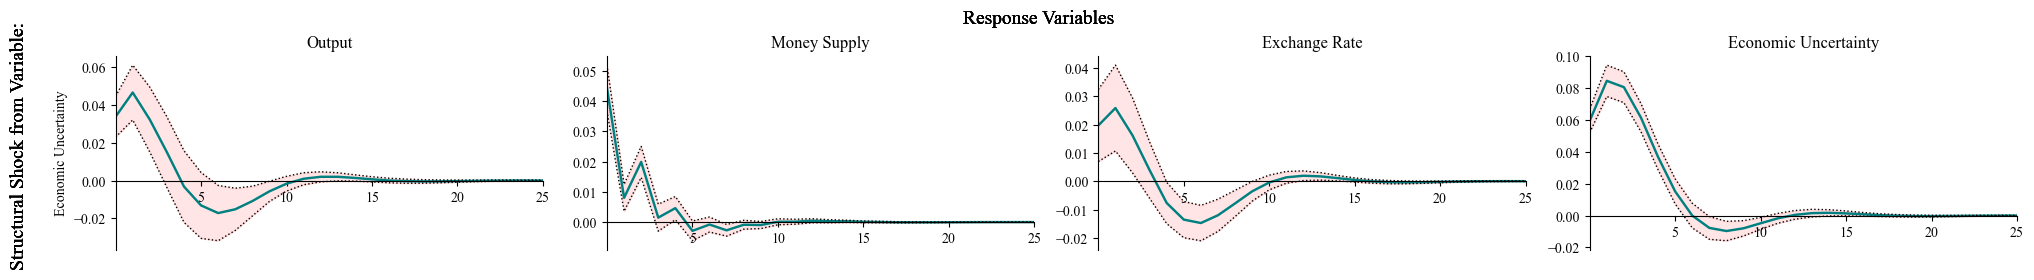

In [42]:
SVAR_IRC.IRF_Combined_Plots(
    linear_combinations = None, # None or linear_combinations
    Bootstrap_Matrix = IRFmat,
    confidence_type = "Delta",  # or "Efron" can be extended.
    responses = [1,2,3,4],      # None = All = [1,2,...,K] and can be any combination e.g [3,1]
    shocks = [4],         # None = All = [1,2,...,K] and can be any combination e.g [2]
    z_values = [68],            # mulitple e.g. z_values=[95,68]
    Baseline = irf,             
    Info="Wild",                # VEC_Bootstrap() setting
    )

## $\text{Q16}$
An alternative to using the MATLAB solver to compute the $B^{-1}_0$ matrix is to use the approach suggested by Warne (1993). Outline this approach and show how the Warne approach can b e used to identify the structural shocks in your preferred VEC model. Discuss both the identification of permanent and transitory shocks.

In [43]:
Beta_theory = np.array([[phi,1,-1,0],[0,0,0,1]])
Aest, _, _, _ = SVAR_IRC.VECMknown(beta=Beta_theory.T)
Xi, SIGMA, _ = SVAR_IRC.Implement_identication(model = 3, rank=rank, beta = Beta_theory.T, ML=True)

In [44]:
invB0 = least_squares(lambda B0inv_flat: SVAR_IRC.Restrictions(B0inv_flat, B0inv_R=B_R, Upsilon_R=U_R, Xi=Xi, SIGMA=SIGMA,Beta=Beta_theory),
                        np.random.randn(K * K))#, xtol=1e-1000000, gtol=1e-1000000, max_nfev=30000)

B0inv = invB0.x.reshape((K, K))
B0inv[:, B0inv.diagonal() < 0] *= -1

print("B_0^{-1}(B_0^{-1})'-\Sigma = 0        ",np.allclose((B0inv @ B0inv.T - SIGMA), 0))
print("\\beta'\\Upsilon = 0                    ",np.allclose((Beta_theory @ Xi @ B0inv), 0))
print("(B_0^{-1} \Sigma @ B_0^{-1})' = I_K   ",np.allclose((np.linalg.inv(B0inv) @ SIGMA @ np.linalg.inv(B0inv).T), np.eye(K)))
Upsilon_solve = Xi @ B0inv
B0inv_solve = B0inv

print("\nB^{-1}_0 =\n",SVAR_IT.To_Matrix(B0inv,short=False))
print("\n\\Upsilon =\n",SVAR_IT.To_Matrix(Xi @ B0inv,short=False))

B_0^{-1}(B_0^{-1})'-\Sigma = 0         True
\beta'\Upsilon = 0                     True
(B_0^{-1} \Sigma @ B_0^{-1})' = I_K    True

B^{-1}_0 =
 \begin{pmatrix}
0.07298 & -0.01097 & 0.05243 & 0.03458 \\
0.00421 & 0.04990 & -0.03242 & 0.04407 \\
-0.06565 & 0.03511 & 0.06993 & 0.02096 \\
-0.02358 & -0.05758 & 0.00000 & 0.05956 \\
\end{pmatrix}

\Upsilon =
 \begin{pmatrix}
0.36855 & -0.00000 & -0.00000 & 0.00000 \\
0.02928 & 0.05686 & -0.00000 & 0.00000 \\
-0.04914 & 0.05686 & 0.00000 & -0.00000 \\
0.00000 & 0.00000 & 0.00000 & 0.00000 \\
\end{pmatrix}


In [45]:
Beta_theory_latex = Matrix(Beta_theory)
Upsilon0_latex = Matrix([[symbols(f"\\Upsilon_{{{i+1}{j+1}}}^0") for j in range(int(K))] for i in range(int(K-rank))])

def matrix_to_latex(matrix):
    return r"\begin{pmatrix}" + r"\\ ".join([" & ".join(map(str, row)) for row in matrix.tolist()]) + r"\end{pmatrix}"

latex_expr = (fr"\begin{{equation}} 0=\underset{{({Beta_theory_latex.shape[0]}\times{int(rank)})}}{{\underset{{{Beta_theory_latex.shape}}}{{\beta'}} \underset{{({int(K)}\times{int(rank)})}}{{\Upsilon_0}}}} = " + matrix_to_latex(Beta_theory_latex) + matrix_to_latex(Upsilon0_latex.T) + "=" + matrix_to_latex(Beta_theory_latex * Upsilon0_latex.T) +r"\end{equation}").replace("*", "\\cdot")
display(Math(latex_expr.replace(", ","\\times ")))

<IPython.core.display.Math object>

In [46]:
Upsilon0 = np.array([[1,0],
                     [-phi,1],
                     [0,1],
                     [0,0]])

print("Beta @ Upsilon =",(Beta_theory @ Upsilon0)[0], " ~ ", "Valid" if np.all(Beta_theory @ Upsilon0 == 0) else "Not valid")

Beta @ Upsilon = [0.0000 0.0000]  ~  Valid


## $\text{Q17}$
Code this identification and compute the implied $B^{-1}_0$ matrix and show that it is identical to the one found by the solver. Please, provide the code you are using in the appendix.

In [47]:
pipit = np.dot(np.dot(np.dot(np.dot(np.linalg.inv(np.dot(Upsilon0.T,Upsilon0)),Upsilon0.T),Xi),SIGMA),np.dot(np.dot(np.linalg.inv(np.dot(Upsilon0.T,Upsilon0)),Upsilon0.T),Xi).T)            
pimat = np.linalg.cholesky(pipit)

Upsilon = np.dot(Upsilon0,pimat)                       
Fk = np.dot(np.dot(np.linalg.inv(np.dot(Upsilon.T,Upsilon)),Upsilon.T),Xi)
print('Fk matrix\n',Fk)

Umat = np.array([[1,0,0,0],[0,0,0,1]])

if Umat is None:
   Umat = np.zeros((int(rank), K))  # Antager en nulmatrix af størrelse r x K
   for i in range(1, int(rank) + 1):
      Umat[i - 1, K - i] = 1  # Python-indeks starter fra 0

if np.linalg.det(np.dot(Umat,Aest)) == 0:
   print('\n Identification of transitory shock is invalid')
else:
   print('\n Identification of transitory shocks is valid')

xi = np.dot(Aest,np.linalg.inv(np.dot(Umat,Aest)))  

i=0
while i < K:
   j=0
   while j< int(rank):
      if abs(xi[i,j]) < 1E-8: #just to make sure that elements are = 0
         xi[i,j] = 0
      j=j+1
   i=i+1

qr=np.linalg.cholesky(np.dot(np.dot(xi.T,np.linalg.inv(SIGMA)),xi))                   
Fr=np.dot(np.dot(np.linalg.inv(qr),xi.T),np.linalg.inv(SIGMA))
print('\n Fr matrix\n',Fr)

# Putting it all together to compute B0inv
invB0 = np.linalg.inv(np.vstack((Fk,Fr)))
invB0[:, invB0.diagonal() < 0] *= -1


print("\nB_0^{-1}\n",invB0)
print("")
print('\n(1) beta*Xi should be zero\n',np.dot(Beta_theory,Xi))
print('\n(2) beta*Upsilon_0 should be zero\n',np.dot(Beta_theory,Upsilon0))
print('\n(3) C(1)*B0^{-1} should be Upsilon~zeros(K,r)\n',np.dot(-Xi,invB0))
print('\nwhere Upsilon\n',Upsilon)
print('\n(4) Covariance matrix of structural shocks w_t should be I_K\n',np.dot(np.dot(np.linalg.inv(invB0),SIGMA),np.linalg.inv(invB0).T))
print('\nShould be diagonal\n',np.dot(np.dot(np.dot(np.dot(np.linalg.inv(qr),xi.T),np.linalg.inv(SIGMA)),xi),np.linalg.inv(qr.T))    )
print('\nThis compares Upsilon solver and closed form solution\n',Upsilon[:,0:K-int(rank)+1],'\n',Upsilon_solve[:,0:K-int(rank)+1],"\n")
Upsilon_Warne = np.dot(Xi,invB0)
B0inv_Warne = invB0

Fk matrix
 [[7.7593 1.2516 -5.2378 -3.5874]
 [0.3231 8.5142 3.7049 -7.7913]]

 Identification of transitory shocks is valid

 Fr matrix
 [[6.1077 -5.7156 7.0713 -1.8044]
 [3.3846 8.7266 1.5077 7.8364]]

B_0^{-1}
 [[0.0730 -0.0110 0.0524 0.0346]
 [0.0042 0.0499 -0.0324 0.0441]
 [-0.0656 0.0351 0.0699 0.0210]
 [-0.0236 -0.0576 0.0000 0.0596]]


(1) beta*Xi should be zero
 [[0.0000 0.0000 -0.0000 -0.0000]
 [0.0000 0.0000 0.0000 0.0000]]

(2) beta*Upsilon_0 should be zero
 [[0.0000 0.0000]
 [0.0000 0.0000]]

(3) C(1)*B0^{-1} should be Upsilon~zeros(K,r)
 [[-0.3686 -0.0000 0.0000 0.0000]
 [-0.0293 -0.0569 -0.0000 0.0000]
 [0.0491 -0.0569 -0.0000 0.0000]
 [0.0000 0.0000 0.0000 0.0000]]

where Upsilon
 [[0.3686 0.0000]
 [0.0293 0.0569]
 [-0.0491 0.0569]
 [0.0000 0.0000]]

(4) Covariance matrix of structural shocks w_t should be I_K
 [[1.0000 0.0000 0.0000 -0.0000]
 [0.0000 1.0000 -0.0000 0.0000]
 [0.0000 -0.0000 1.0000 -0.0000]
 [-0.0000 0.0000 -0.0000 1.0000]]

Should be diagonal
 [[1.0000 -

In [48]:
print("Upsilon  ≈  Upsilon (solve)   ~  ",np.allclose(Upsilon_Warne, Upsilon_solve))
print("B_0^{-1} ≈  B_0^{-1} (solve)  ~  ",np.allclose(B0inv_Warne, B0inv_solve))

print("\nDifference (Maximum)")
print(f"    B_0^{{-1}}:  {np.max(B0inv_Warne - B0inv_solve):.25f}")
print(f"    Upsilon:   {np.max(Upsilon_Warne - Upsilon_solve):.25f}")

def matrix(matrix, name):
    string = f"$$\n{name} = \\begin{{pmatrix}}\n"
    rows, cols = matrix.shape
    for i in range(rows):
        row = " & ".join([f"{matrix[i, j]:.10f}" for j in range(cols)])
        string += row + " \\\\\n"
    string += "\\end{pmatrix}\n$$"
    return string

display(Math(matrix(B0inv_solve, "\\underset{(\\textit{Solver})}{B_{0}^{-1}}")))
display(Math(matrix(B0inv_Warne, "\\underset{(\\textit{Warne})}{B_{0}^{-1}}")))
print("")
display(Math(matrix(Upsilon_solve, "\\underset{(\\textit{Solver})}{\\Upsilon_{0}}")))
display(Math(matrix(Upsilon_Warne, "\\underset{(\\textit{Warne})}{\\Upsilon_{0}}")))

Upsilon  ≈  Upsilon (solve)   ~   True
B_0^{-1} ≈  B_0^{-1} (solve)  ~   True

Difference (Maximum)
    B_0^{-1}:  0.0000000000016708578964852
    Upsilon:   0.0000000000000822675261247


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [49]:
if "True" == "True":
    print(matrix(B0inv_solve,   r"\underset{(\textit{Solver})}{B_{0}^{-1}}"),"\n")
    print(matrix(B0inv_Warne,   r"\underset{(\textit{Warne})}{B_{0}^{-1}}" ),"\n")
    print(matrix(Upsilon_solve, r"\underset{(\textit{Solver})}{\Upsilon_0}"),"\n")
    print(matrix(Upsilon_Warne, r"\underset{(\textit{Warne})}{\Upsilon_0}" ),"\n")

$$
\underset{(\textit{Solver})}{B_{0}^{-1}} = \begin{pmatrix}
0.0729800341 & -0.0109691808 & 0.0524323914 & 0.0345767756 \\
0.0042148461 & 0.0498960808 & -0.0324174420 & 0.0440740089 \\
-0.0656467379 & 0.0351108932 & 0.0699266870 & 0.0209581568 \\
-0.0235838141 & -0.0575816300 & 0.0000000000 & 0.0595629117 \\
\end{pmatrix}
$$ 

$$
\underset{(\textit{Warne})}{B_{0}^{-1}} = \begin{pmatrix}
0.0729800341 & -0.0109691808 & 0.0524323914 & 0.0345767756 \\
0.0042148461 & 0.0498960808 & -0.0324174420 & 0.0440740089 \\
-0.0656467379 & 0.0351108932 & 0.0699266870 & 0.0209581568 \\
-0.0235838141 & -0.0575816300 & 0.0000000000 & 0.0595629117 \\
\end{pmatrix}
$$ 

$$
\underset{(\textit{Solver})}{\Upsilon_0} = \begin{pmatrix}
0.3685548356 & -0.0000000000 & -0.0000000000 & 0.0000000000 \\
0.0292844943 & 0.0568580107 & -0.0000000000 & 0.0000000000 \\
-0.0491439747 & 0.0568580107 & 0.0000000000 & -0.0000000000 \\
0.0000000000 & 0.0000000000 & 0.0000000000 & 0.0000000000 \\
\end{pmatrix}
$$ 

$$
\underse